In [1]:
# Thunder-related libraries, for image processing
import thunder as td
from registration import CrossCorr
from regression import FastLinearRegression

In [2]:
sparkOn = False # set True if Spark is installed and used as computation engine (on a cluster). 
                # set False if running the code in local mode

tifFormat = True #True if images are TIFF files
                #False if images in binary stack format (set correct dimensions for import) 

In [3]:
# all other libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('./lib')
if sparkOn: 
    sc.addPyFile('./lib/compress.py') 
import importEphys as ime
import conv as conv
import compress as compress
from skimage.external import tifffile
import time
import glob, os

Unzip `2014-08-01fish2_H2B/raw.zip` file before running the code.

In [4]:
# Set up YOUR data directory
expDir = 'C:/Users/user/Documents/ZebrafishFunctionalMaps_LinearRegression/2014-08-01fish2_H2B/'
rawDir = expDir + 'raw/' #storage of an imaging/behavior session
procDir = expDir + 'proc/' #storage for processed data (functinal maps)
fName = 'ephys.10ch'
if not os.path.exists(procDir):
        os.mkdir(procDir)

In [5]:
# if using Spark, uncompress the imaging data from BZ2 files in parallel mode
if sparkOn: 
    fileList = glob.glob(rawDir + 'TM*.stack.bz2')
    sc.parallelize(fileList).foreach(compress.bz2uncompressStack)

### Parse behavior file

In [13]:
# read the behavior data
ephys = ime.import10ch(rawDir + fName)
stackInitInd = ime.stackInits(ephys)
drift = np.squeeze(ephys['drift'][stackInitInd])
Fdrift = np.zeros(drift.shape)
Bdrift = np.zeros(drift.shape)
FdriftInd = np.where(drift>0)[0]
BdriftInd = np.where(drift<0)[0]
Fdrift[FdriftInd] = drift[FdriftInd]
Bdrift[BdriftInd] = -drift[BdriftInd]
# separate behavior during Foward, Backward, and No drift conditions
drift6K = np.squeeze(ephys['drift'][:]) #6K because ephys sample rate is 6KHz
FdriftInd6K = np.where(drift6K>0)[0]
BdriftInd6K = np.where(drift6K<0)[0]
NoDriftInd6K = np.where(drift6K==0)[0]

ch0Forw = np.zeros(ephys['fltCh0'][:].shape)
ch1Forw = np.zeros(ch0Forw.shape)
ch0Backw = np.zeros(ch0Forw.shape)
ch1Backw = np.zeros(ch0Forw.shape)
ch0NoDrift = np.zeros(ch0Forw.shape)
ch1NoDrift = np.zeros(ch0Forw.shape)

# fill channels with default values, using 50% percentile
ch0Forw[:] = np.percentile(ephys['fltCh0'][:],50)
ch0Backw = ch0Forw.copy()
ch0NoDrift = ch0Forw.copy()
ch1Forw[:] = np.percentile(ephys['fltCh1'][:],50)
ch1Backw = ch1Forw.copy()
ch1NoDrift = ch1Forw.copy()

# fill the rest with actual filtere signal
ch0Forw[FdriftInd6K] = ephys['fltCh0'][FdriftInd6K]
ch0Backw[BdriftInd6K] = ephys['fltCh0'][BdriftInd6K]
ch0NoDrift[NoDriftInd6K] = ephys['fltCh0'][NoDriftInd6K]

ch1Forw[FdriftInd6K] = ephys['fltCh1'][FdriftInd6K]
ch1Backw[BdriftInd6K] = ephys['fltCh1'][BdriftInd6K]
ch1NoDrift[NoDriftInd6K] = ephys['fltCh1'][NoDriftInd6K]

In [14]:
# Filter the behavior and prepare regressors
stackDurations = np.diff(stackInitInd)

ch0ForwSubsampled = np.zeros(len(stackInitInd))
ch0BackwSubsampled = np.zeros(len(stackInitInd))
ch0NoDriftSubsampled = np.zeros(len(stackInitInd))
ch1BackwSubsampled = np.zeros(len(stackInitInd))
ch1ForwSubsampled = np.zeros(len(stackInitInd))
ch1NoDriftSubsampled = np.zeros(len(stackInitInd))


for i in range(0,len(stackInitInd)-1):
    ch0ForwSubsampled[i] = np.max(ch0Forw[stackInitInd[i]:stackInitInd[i]+stackDurations[i]])
    ch0BackwSubsampled[i] = np.max(ch0Backw[stackInitInd[i]:stackInitInd[i]+stackDurations[i]])
    ch0NoDriftSubsampled[i] = np.max(ch0NoDrift[stackInitInd[i]:stackInitInd[i]+stackDurations[i]])
    ch1ForwSubsampled[i] = np.max(ch1Forw[stackInitInd[i]:stackInitInd[i]+stackDurations[i]])
    ch1BackwSubsampled[i] = np.max(ch1Backw[stackInitInd[i]:stackInitInd[i]+stackDurations[i]])
    ch1NoDriftSubsampled[i] = np.max(ch1NoDrift[stackInitInd[i]:stackInitInd[i]+stackDurations[i]]) 

# Adjust the baseline of behavior by clipping between lowest 1% and highest 99%, to avoid spiking artifacts

behaviorForw = ch0ForwSubsampled + ch1ForwSubsampled

behaviorForwClipped = np.clip(behaviorForw,np.percentile(behaviorForw,1),np.percentile(behaviorForw,99)) - np.percentile(behaviorForw,1)

behaviorBackw = ch0BackwSubsampled + ch1BackwSubsampled
behaviorBackwClipped = np.clip(behaviorBackw,np.percentile(behaviorBackw,1),\
                               np.percentile(behaviorBackw,99)) - np.percentile(behaviorBackw,1)

behaviorNoDrift = ch0NoDriftSubsampled + ch1NoDriftSubsampled
behaviorNoDriftClipped = np.clip(behaviorNoDrift,np.percentile(behaviorNoDrift,1),\
                               np.percentile(behaviorNoDrift,99)) - np.percentile(behaviorNoDrift,1)

# Convolve the regressors with double-exp kernel
tau = 3.0 #decay constant, in stacks
tau1 = 1.0 # kinda rise time, must be < tau

behaviorForwConv = conv.conv2exp(behaviorForwClipped,tau1,tau)
behaviorBackwConv = conv.conv2exp(behaviorBackwClipped,tau1,tau)
behaviorNoDriftConv = conv.conv2exp(behaviorNoDriftClipped,tau1,tau)

FdriftConv = conv.conv2exp(Fdrift,tau1,tau)
BdriftConv = conv.conv2exp(Bdrift,tau1,tau)

(0, 180)

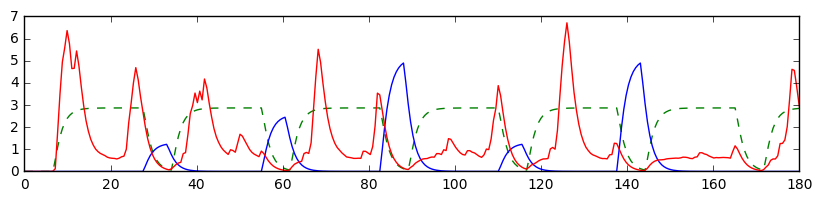

In [15]:
# Optional: plot the regressors
plt.figure(figsize=(10,2))
plt.plot(ephys['t'][stackInitInd],FdriftConv/FdriftConv.std(),'--g',\
         ephys['t'][stackInitInd],BdriftConv/BdriftConv.std(),'-b',\
         ephys['t'][stackInitInd],behaviorForwConv/behaviorForwConv.std(),'r')
plt.xlim(0,180)

In [10]:
np.save(procDir + 'regressors.npy',np.vstack((behaviorForwConv,FdriftConv,BdriftConv)))

## Image processing (requires Thunder)

In [11]:
dims = (41, 256, 512)
numFrames = 100
if sparkOn:
    # load images using  distributed computing engine Spark 
    if tifFormat:
        dat = td.images.fromtif(rawDir, npartitions=numFrames, engine=sc)
    else:
        dat = td.images.frombinary(rawDir, shape = dims, ext='tif', npartitions=numFrames, engine=sc)
else:
    #load images in local context
    if tifFormat:
        dat = td.images.fromtif(rawDir, npartitions=numFrames)
    else:
        dat = td.images.frombinary(rawDir, shape = dims, ext='tif', npartitions=numFrames)

# length of reference, in frames
refLength = 10
# reference timerange, last 10 frames
refR = np.array([numFrames - refLength,numFrames])
# filter parameters
filt = {}
filt['filter'] = 'median'
filt['footprint'] = 3

print('Taking reference from planes ' + str(refR[0]) + ' to ' + str(refR[-1]))

Taking reference from planes 90 to 100


In [12]:
dat.count

<bound method Images.count of Images
mode: local
dtype: uint16
shape: (100L, 41L, 256L, 512L)>

### Run registration using a cropped dataset

In [13]:
zStart = 10 #starting plane of registration 
zEnd = 30 #ending plane
datCrop = dat[:,zStart:zEnd, :, :] # take sub-stack
reference = datCrop[refR[0]:refR[1],:,:,:].mean().toarray()

register = CrossCorr(axis = 0) 
model = register.fit(datCrop.median_filter(3), reference=reference)
deltas = model.toarray()

# set registration shifts
xshift = np.floor(np.median(deltas[:,:,1],axis=1))
yshift = np.floor(np.median(deltas[:,:,0],axis=1))

for ti in range(len(model.transformations)):
    model.transformations[(ti,)].delta = []
    for zi in range(dims[0]):
        model.transformations[(ti,)].delta.append([yshift[ti],xshift[ti]])
        
# apply registration parameters to the full data    
datRegistered = model.transform(dat)

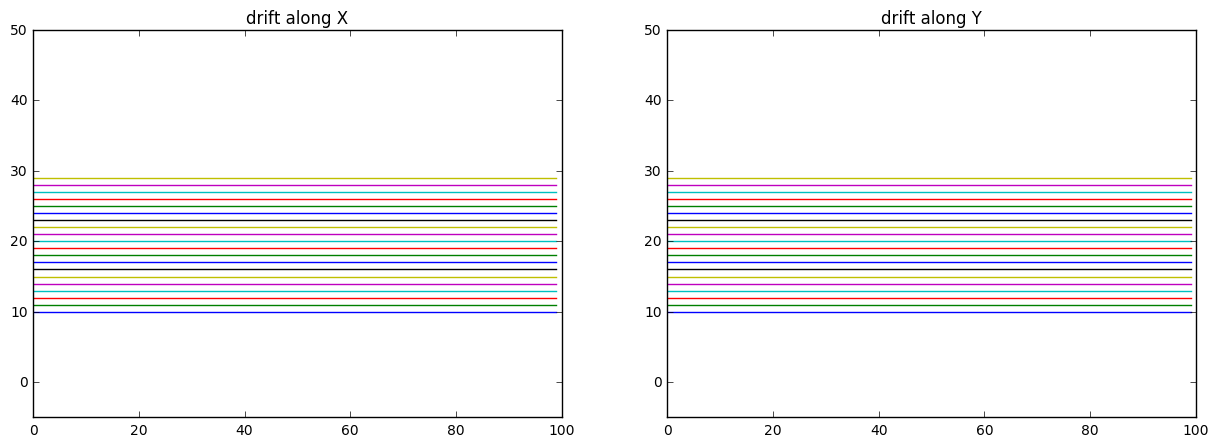

In [14]:
#Check XY-drift, Straight lines mean no drift
f, axarr = plt.subplots(1, 2,figsize=(15,5))
for x in range(deltas.shape[1]):
    axarr[0].plot(deltas[:,x,1] + x + zStart)   
    axarr[0].set_title('drift along X')
    axarr[0].set_ylim(-5,50)
    
    axarr[1].plot(deltas[:,x,0] + x + zStart)  
    axarr[1].set_title('drift along Y')
    axarr[1].set_ylim(-5,50)

##### Convert to time series

In [15]:
%%time
imSeries = datRegistered.toseries().normalize()
imSeries.count()

Wall time: 4min 53s


##### Do regression against Motor, Fdrift and Bdrift

In [16]:
# Prepare regressors
indRange = np.arange(100,200)
regressors = np.column_stack((behaviorForwConv[indRange]/behaviorForwConv[indRange].std(),\
    FdriftConv[indRange]/FdriftConv[indRange].std(),\
    BdriftConv[indRange]/BdriftConv[indRange].std()))
regressors.shape

(100L, 3L)

In [17]:
%%time
model = FastLinearRegression(fit_intercept=True).fit(regressors, imSeries)
results = model.betas_and_scores.toarray()
betas, stats = results[:,:,:, 1:4], results[:,:,:, 4]

Wall time: 10min 5s


In [18]:
# save betas and stats
np.save(procDir + 'betas.npy',betas)
np.save(procDir + 'stats.npy',stats)

In [19]:
#Convert (regression coeffs x R2) into weights
imMotorForw = (betas[:,:,:,0]*stats)
imForw = (betas[:,:,:,1]*stats)
imBackw = (betas[:,:,:,2]*stats)

(-0.25, 1)

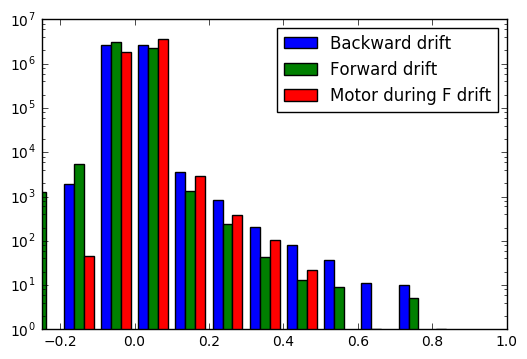

In [20]:
# check histograms of weights
plt.hist([ imBackw.flatten(), imForw.flatten(), imMotorForw.flatten()],np.arange(-1,1,0.1), log = True, \
               color = ['blue', 'green', 'red'],\
               label=['Backward drift', 'Forward drift', 'Motor during F drift'])
plt.legend()
plt.xlim([-0.25, 1])

##### Adjust gamma and save in RGB image (tiff) files

In [21]:
# gamma-adjustment, save only positive weights
gamma = 0.5
imMgamma = np.zeros(imMotorForw.shape)
imMgamma[imMotorForw > 0] = imMotorForw[imMotorForw > 0]**gamma

imFgamma = np.zeros(imForw.shape)
imFgamma[imForw > 0] = imForw[imForw > 0]**gamma

imBgamma = np.zeros(imBackw.shape)
imBgamma[imBackw > 0] = imBackw[imBackw > 0]**gamma

# scaling between refMin and refMax before saving as 8-bit images
refMin = 0
refMax = 1.0

imTiffR = np.clip(imMgamma/refMax*(2**8-1),refMin,2**8-1)
tifffile.imsave(procDir + 'motorDuringForw_REDgamma0.5.tif',imTiffR.astype(np.uint8))

imTiffG = np.clip(imFgamma/refMax*(2**8-1),refMin,2**8-1)
tifffile.imsave(procDir + 'forwDrift_GREENgamma0.5.tif',imTiffG.astype(np.uint8))

imTiffB = np.clip(imBgamma/refMax*(2**8-1),refMin,2**8-1)
tifffile.imsave(procDir + 'backwDrift_BLUEgamma0.5.tif',imTiffB.astype(np.uint8))

compositeTiff = np.array([imTiffR.T, imTiffG.T, imTiffB.T])
tifffile.imsave(procDir + 'compositeRGBgamma0.5.tif',compositeTiff.T.astype(np.uint8))

In [22]:
# save reference anatomy stack
refStack = dat[-10:-1,:,:,:].mean().toarray()
tifffile.imsave(procDir + 'ref.tif',refStack.astype(np.uint16))